In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
x = np.linspace(0,50,501)

In [50]:
#x

In [51]:
y = np.sin(x)

In [52]:
#y

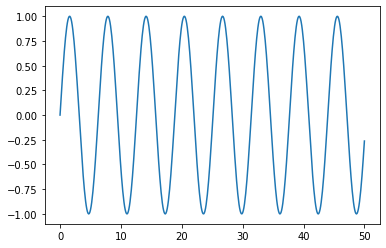

In [53]:
plt.plot(x,y)

In [54]:
df = pd.DataFrame(data=y,index=x,columns=['sine'])
df.head()

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [55]:
# train test split

In [56]:
len(df)

501

In [57]:
test_perc = 0.1

In [58]:
len(df)*test_perc # how many of total should be the test samples

50.1

In [59]:
test_point = np.round(len(df)*test_perc)

In [60]:
test_point

50.0

In [61]:
test_index = int(len(df)-test_point)

In [62]:
train = df.iloc[:test_index]

In [63]:
test = df.iloc[test_index:]

In [64]:
# now scaling but it would be slightly different from normal scaling as now we also need to scale y because it's also our input
# for next recurrent neuron.

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
scaler = MinMaxScaler()

In [67]:
scaled_train = scaler.fit_transform(train)

In [68]:
scaled_test = scaler.transform(test)

In [69]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [70]:
#help(TimeseriesGenerator)

In [71]:
length = 2
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train,
                               targets=scaled_train,
                               length=length,
                               batch_size=batch_size)

In [72]:
len(scaled_train)

451

In [73]:
len(generator) # 451-length

449

In [74]:
X,y = generator[0]

In [75]:
X # becoz length is 2

array([[[0.49999912],
        [0.54991622]]])

In [76]:
y

array([[0.59933458]])

In [77]:
#scaled_train

In [78]:
X,y = generator[1]

In [79]:
X

array([[[0.54991622],
        [0.59933458]]])

In [80]:
y

array([[0.64776041]])

In [81]:
#scaled_train

In [82]:
# but the length shouldn't be decided randomly it should be alteast sufficient to catch the trend or patterns which our 
# sequence is following, like if our timestamp is showing distributions as a seasonal trend in a year than our length parameter
# which actually represent how many data points we'll observe to predict the next datapoint/target should be large enough
# to take under consideration the datapoints atleast of a year (like 12 months)

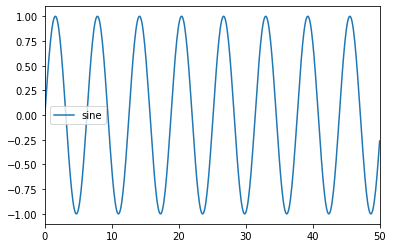

In [83]:
# for our dataset
df.plot()

In [84]:
# so let's feed in 50 datapoints (bcoz for our timestamp we have 100 points per 10)

In [107]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train,
                               targets=scaled_train,
                               length=length,
                               batch_size=batch_size)

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [109]:
n_features = 1 # bcoz we just have one featue in this case

In [110]:
model = Sequential()

model.add(SimpleRNN(50,input_shape=(length,n_features))) # for simple rnn layer no. of neurons is highly linked to length parameter.
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [111]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 4s 11ms/step - loss: 0.0025
Epoch 2/5
401/401 [==============================] - 4s 9ms/step - loss: 7.1254e-05
Epoch 3/5
401/401 [==============================] - 4s 9ms/step - loss: 1.4813e-04
Epoch 4/5
401/401 [==============================] - 4s 9ms/step - loss: 6.5078e-04
Epoch 5/5
401/401 [==============================] - 4s 9ms/step - loss: 1.3137e-05


In [113]:
losses = pd.DataFrame(model.history.history)

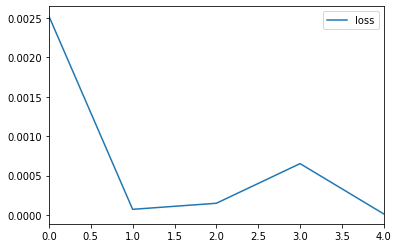

In [114]:
losses.plot()

In [115]:
first_eval_batch = scaled_train[-length:]

In [118]:
first_eval_batch = first_eval_batch.reshape((1,length,n_features))

In [119]:
model.predict(first_eval_batch)

array([[0.95275205]], dtype=float32)

In [120]:
scaled_test[0]

array([0.94955134])

In [121]:
# not too bad !!

In [123]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # moving the timestamp 1 step ahead i.e we'll 
    # remove first observation and instead add a new predicted observation.

In [124]:
test_predictions

[array([0.95275205], dtype=float32),
 array([0.97301495], dtype=float32),
 array([0.98809373], dtype=float32),
 array([0.9988642], dtype=float32),
 array([1.005129], dtype=float32),
 array([1.0064683], dtype=float32),
 array([1.0021096], dtype=float32),
 array([0.9922871], dtype=float32),
 array([0.9787381], dtype=float32),
 array([0.9611692], dtype=float32),
 array([0.9386906], dtype=float32),
 array([0.91139716], dtype=float32),
 array([0.88107055], dtype=float32),
 array([0.8476428], dtype=float32),
 array([0.81145525], dtype=float32),
 array([0.77169114], dtype=float32),
 array([0.7296806], dtype=float32),
 array([0.68586975], dtype=float32),
 array([0.64092535], dtype=float32),
 array([0.5942585], dtype=float32),
 array([0.5463607], dtype=float32),
 array([0.49843127], dtype=float32),
 array([0.45075768], dtype=float32),
 array([0.4037301], dtype=float32),
 array([0.35777673], dtype=float32),
 array([0.31310436], dtype=float32),
 array([0.27095288], dtype=float32),
 array([0.23135

In [125]:
true_predictions = scaler.inverse_transform(test_predictions)

In [126]:
true_predictions

array([[ 0.90549861],
       [ 0.94602408],
       [ 0.9761814 ],
       [ 0.99772211],
       [ 1.01025162],
       [ 1.01293023],
       [ 1.004213  ],
       [ 0.98456807],
       [ 0.95747034],
       [ 0.92233273],
       [ 0.87737593],
       [ 0.82278948],
       [ 0.76213676],
       [ 0.69528175],
       [ 0.62290727],
       [ 0.54337969],
       [ 0.45935928],
       [ 0.37173829],
       [ 0.2818502 ],
       [ 0.18851723],
       [ 0.09272237],
       [-0.00313568],
       [-0.09848208],
       [-0.1925365 ],
       [-0.28444249],
       [-0.37378651],
       [-0.45808879],
       [-0.53728619],
       [-0.61015673],
       [-0.67619561],
       [-0.73466724],
       [-0.78551926],
       [-0.82710837],
       [-0.85932719],
       [-0.88240126],
       [-0.8964155 ],
       [-0.9014119 ],
       [-0.89617516],
       [-0.88088128],
       [-0.8573005 ],
       [-0.82585923],
       [-0.78585436],
       [-0.73681871],
       [-0.68020411],
       [-0.61781327],
       [-0

In [127]:
test['predictions'] = true_predictions

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [128]:
test

,sine,predictions
45.1,0.899097,0.905499
45.2,0.938307,0.946024
45.3,0.968142,0.976181
45.4,0.988304,0.997722
45.5,0.998591,1.010252
45.6,0.998900,1.012930
45.7,0.989229,1.004213
45.8,0.969673,0.984568
45.9,0.940429,0.957470
46.0,0.901788,0.922333


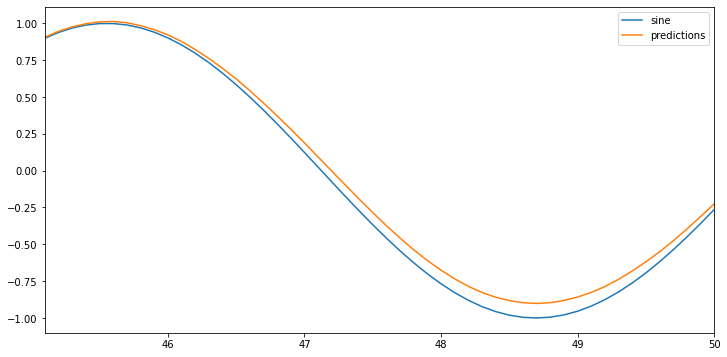

In [129]:
test.plot(figsize=(12,6)) # so we are able to somewhat memic sine character but as we move ahead on x axis we are more off from 
# true values because we are keep on increasing more previously predicted value in current batch.

In [132]:
from tensorflow.keras.callbacks import EarlyStopping

In [133]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [134]:
length = 49

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,
                               batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,
                                          batch_size=1)

In [136]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features))) # for simple rnn layer no. of neurons is highly linked to length parameter.
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [137]:
model.fit_generator(generator,
                   validation_data=validation_generator,
                   epochs=20,
                   callbacks=[early_stop])

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
402/402 [==============================] - 17s 44ms/step - loss: 0.0156 - val_loss: 1.2949e-05
Epoch 2/20
402/402 [==============================] - 16s 40ms/step - loss: 2.3241e-04 - val_loss: 1.0733e-04
Epoch 3/20
402/402 [==============================] - 16s 41ms/step - loss: 3.6336e-04 - val_loss: 1.7896e-05


In [138]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # moving the timestamp 1 step ahead i.e we'll 
    # remove first observation and instead add a new predicted observation.

In [139]:
true_predictions = scaler.inverse_transform(test_predictions)

In [140]:
test['predictions'] = true_predictions

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


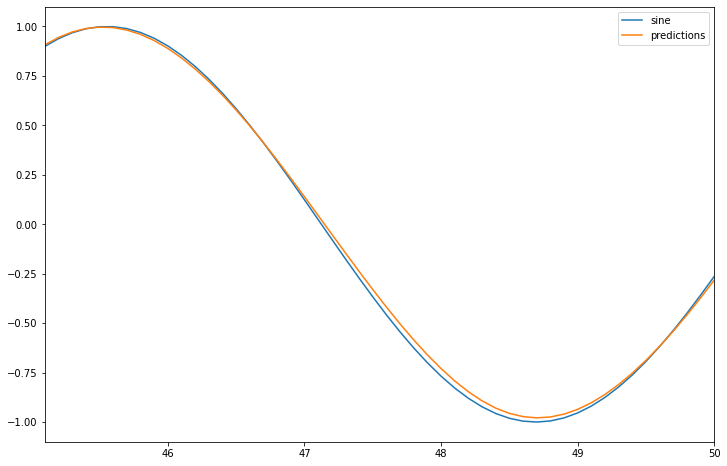

In [142]:
test.plot(figsize=(12,8))

In [143]:
# let's forecast the predictions i.e beyond 50 for that we need to retrain on whole data as train set

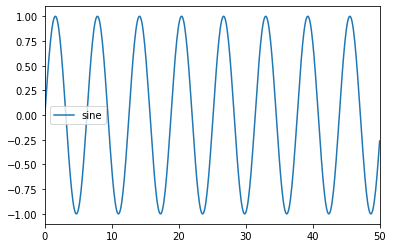

In [144]:
df.plot()

In [145]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [146]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,
                               batch_size=1)

In [147]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features))) # for simple rnn layer no. of neurons is highly linked to length parameter.
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [148]:
model.fit_generator(generator,epochs=3) # as in previous training the early stop stopped training at optimal epoch count of 3

Epoch 1/3
452/452 [==============================] - 20s 45ms/step - loss: 0.0087
Epoch 2/3
452/452 [==============================] - 19s 42ms/step - loss: 2.2844e-04
Epoch 3/3
452/452 [==============================] - 19s 42ms/step - loss: 1.2632e-04


In [149]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(25):
    
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) # moving the timestamp 1 step ahead i.e we'll 
    # remove first observation and instead add a new predicted observation.

In [150]:
forecast = scaler.inverse_transform(forecast)

In [152]:
#df

In [153]:
25*0.1

2.5

In [154]:
forecast_index = np.arange(50.1,52.6,step=0.1)

In [155]:
len(forecast_index)

25

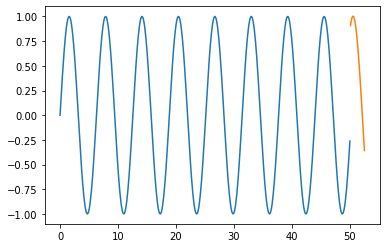

In [157]:
plt.plot(df.index,df['sine'])
plt.plot(forecast_index,forecast)
# this disconnect is just bcoz these two dfs are different and tthere is no relation to connect them. but one way to do so
# is to use pd.concatenate but it's actually not required

In [158]:
# hola !! we are able to forecast